# Neural Networks (Part 2): Going Deeper

In part 2 of this neural networks series of tutorials we'll go into a grab bag of useful techniques, more advanced ideas that make it easier to train deeper neural networks. We'll discuss:
- activation functions: sigmoids, ReLUs
- learning rate tuning: learning rate finders, schedulers, warmups and restarts
- regularization: weight decay, dropout
- normalization: batch norm, layer norm

We won't discuss major new architecture improvements yet, just dropout and normalization. Nor will we discuss optimizers, yet.

We'll again load the usual libraries we'll need, set a seed, and set a device for those who'd prefer to work on the GPU. We'll also import the same data plotting function from the previous tutorial, and define a function to create an MLP with arbitrary many layers to keep us from having to manually define them ourselves (error prone, and a pain when you start using many layers).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
def plot_data(X, y, X_test=None, y_test=None, model=None, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    fig, ax = plt.subplots(figsize=(8, 8))

    classes = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if model is not None:
        grid = torch.from_numpy(grid).float()
        yhat = model(grid).argmax(dim=1).detach().numpy().reshape(xx.shape)
        ax.contourf(xx, yy, yhat, alpha=0.2, cmap=plt.cm.rainbow)
        plt.axis('tight')

    for j, color in zip(classes, colors):
        idx = np.where(y == j)
        alpha = 1 if X_test is None else 0.2
        label = f'y={j}' if X_test is None else None
        plt.scatter(X[idx, 0], X[idx, 1], label=label, color=color, edgecolor='black', s=10, alpha=alpha)
        if X_test is not None and y_test is not None:
            idx = np.where(y_test == j)
            plt.scatter(X_test[idx, 0], X_test[idx, 1], label=f'y={j}', color=color, edgecolor='black', s=30, alpha=1)
    plt.title('Decision Surface')
    plt.axis('tight')

    ax.set(aspect='equal', xlabel='$x_1$', ylabel='$x_2$')
    ax.legend(loc='upper right')
    plt.show()
    
def multilayer_mlp(num_features, num_targets, hidden_sizes, p=0, normalization=None, activation=nn.ReLU()):
    """
    Get an arbitrary MLP model with L=len(hidden_sizes)+1 layers
    Optionally, can include a batchnorm and dropout in each layer, and change the activation function
    """
    def get_leaf_layers(m):
        """Used to flatten the layers out so the model doesn't recursively nest"""
        children = list(m.children())
        if not children:
            return [m]
        leaves = []
        for l in children:
            leaves.extend(get_leaf_layers(l))
        return leaves
    hidden_sizes = [num_features] + hidden_sizes
    n_layers = len(hidden_sizes)
    model = nn.Sequential()
    for l in range(n_layers-1):
        linear = nn.Linear(hidden_sizes[l], hidden_sizes[l+1])
        dropout = None if p == 0. else nn.Dropout(p)
        layer_norm = None if normalization is None else normalization(hidden_sizes[l+1])
        blocks = [linear, layer_norm, activation, dropout]
        layer_block = nn.Sequential(*[layer for layer in blocks if layer is not None])
        model = nn.Sequential(*([model] + [layer_block]))
    output = nn.Sequential(nn.Linear(hidden_sizes[-1], num_targets))
    model = nn.Sequential(*([model] + [output]))
    model = nn.Sequential(*get_leaf_layers(model))
    return model

## Activation Functions

Recall that an activation function is any function that follows a linear layer. We've used sigmoid functions thus far for hidden layer activation functions. For output activation functions we've used linear, sigmoid, and softmax funtions.

It turns out that the sigmoid function 
$$\sigma(z) \equiv \frac{1}{1 + e^{-z}}$$ 
is a bad activation function to use for hidden layers. The reason for this is **gradient vanishing**. Because of the sigmoid's elongated S-shape, if $z$ isn't "small" in absolute value, e.g. $|z|=5$, then $\sigma(z)$ will be close to $\pm 1$. In these regions the sigmoid will be pretty flat, meaning its derivative (i.e. its gradient) will be approximately zero. When the gradient is approximately zero, gradient descent stops working, and those parameters don't update anymore. This causes the activations to die off, making them practically useless in the network. They can't contribute anymore to learning. Such dying activations have been shown to be common when one tries to use sigmoids hidden activations for deeper networks.

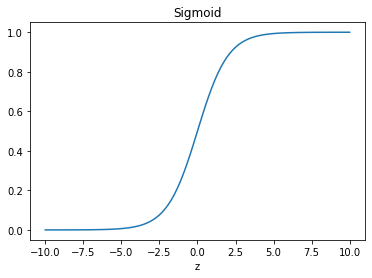

In [5]:
z = torch.linspace(-10, 10, 100)
sigmoid = F.sigmoid(z)
plt.plot(z.numpy(), sigmoid.numpy())
plt.xlabel('z')
plt.title('Sigmoid')
plt.show()

Because of this problem, many other activation functions have been proposed over the years and shown to work much better than the sigmoid for hidden layer activations. The most widely used is what's called the **rectified linear unit**, usually just called **ReLU**, defined by
$$
\text{ReLU}(z) \equiv \max(0, z) = 
\begin{cases}
0, & z < 0 \\
z, & z \geq 0.
\end{cases}
$$
This function is just a truncated line, with all the negative values set to zero.

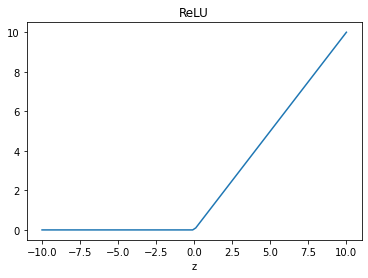

In [6]:
z = torch.linspace(-10, 10, 100)
relu = F.relu(z)
plt.plot(z.numpy(), relu.numpy())
plt.xlabel('z')
plt.title('ReLU')
plt.show()

The ReLU has turned out to work well across many experiments over the past decade for training neural networks, with gradient vanishing issues happening far less than sigmoids. Because of this, it's still by far the most widely used activation function today, even though minor variations of it have since come along and gained some degree of traction. Examples of these are the leaky ReLU, GELU, SELU, Swish, Mish, etc. We'll stick with ReLUs for most of our tutorials since it tends to work pretty well most of the time.

Using a ReLU in pytorch can be done either by using the layer `nn.ReLU` or the function `F.relu`. The other, newer variants just mentioned are accessible as well if you wish to use them.

**Note:** The ReLU is just used for *hidden layers*, not the output layer. For the output layer, you still want to use either the linear, sigmoid, or softmax activation depending on what your task is.

In [7]:
model = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
  (3): Sigmoid()
)

## Learning Rate Tuning

It turns out that the learning rate is the most important hyperparameter to tune when training a model in terms of getting good results. A learning rate too high will cause the loss to explode or fail to decrease, and a learning rate too low will cause the model to converge to a minimum very slowly. Unfortunately, there is no "right" learning rate that works for all situations. A learning rate of say 0.1 may work for one dataset, and be way too big for another dataset. It would thus be helpful to automatically tuning learning rates so we don't have to go through so much trial and error.

When it comes to tuning learning rates, there are two things we have to do:
1. Decide what *initial* learning rate to specify to start training the model.
2. Decide how the learning rate should be adjusted, or *scheduled*, during training.

### Learning Rate Finders

To help with the problem of tuning the initial learning rate we can use a **learning rate finder** (LR finder). An LR finder is a trick for quickly figuring out which learning rates would make the loss decrease quickly, at least initially. What an LR finder does is does is takes a few "fake" iterations of training while steadily increasing the learning rate at each step, starting with a really small learning rate, and finishing with a really large learning rate. At each step the finder records the loss as a function of the learning rate. Once these fake iterations have finished (usually just 100 iterations), this learning rate vs loss curve is plotted on a log scale.

How should one read this curve to pick a good learning rate? You'll usually see a bowl-shaped spot where the loss has a minimum, like is shown in the figure below. You don't want to pick that minimum spot. You want to go left towards where the loss *starts* to decrease, and pick something between that point and the inflection point (roughly speaking, the halfway point between the top and bottom of that part of the curve). As long as you're within an order of magnitude of that region you should be okay.

<img src="https://pyimagesearch.com/wp-content/uploads/2019/08/learing_rate_finder_lr_plot.png" alt="lr-find" width="500">

Rather than tediously implement this LR finder ourselves there's a lightweight python library called `torch_lr_finder` that can do this for us. We'll package this stuff up inside an `lr_find` function so we don't have to remember these specific commands every time. Notice that this library tries its best to suggest a good initial learning rate for you rather than have you try to read it off from the curve. You shouldn't *always* assume they'll give you the best learning rate, but they should put you within an order of magnitude of a good learning rate at least.

**Note:** One subtlety to mention is that this LR finder library expects a pytorch `DataLoader` object as input, which itself takes a pytorch `Dataset` object as input. Since we won't cover these until the next tutorial, I'll just pre-define a pytorch dataset below as `dataset` and pass that into the function, which itself will create the dataloader object to pass into the LR finder.

In [8]:
def lr_find(dataset, model, opt, loss_fn, batch_size=128, plot=True, log_lr=True, **kwargs):
    from torch_lr_finder import LRFinder
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    lr_finder = LRFinder(model, opt, loss_fn, device=device)
    lr_finder.range_test(dataloader, **kwargs)
    lr_finder.plot(log_lr=log_lr)
    lr_finder.reset()

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.20E-01


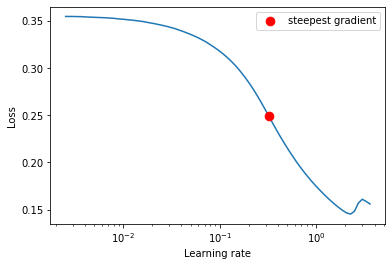

In [9]:
X = torch.rand(1000, 100)
y = torch.rand(1000, 100)
dataset = [(X[i], y[i]) for i in range(len(y))]

model = nn.Sequential(nn.Linear(100, 100), nn.Linear(100, 100), nn.Linear(100, 100))
loss_fn = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=1)
lr_find(dataset, model, opt, loss_fn, start_lr=1e-3, end_lr=10, num_iter=100)

### Learning Rate Schedulers

The other thing to address is how we should tune the learning rate after training has started. We haven't really dealt with this yet, as we've used the same initial learning rates throughout training. But generally, the optimal learning rate when training starts won't be the optimal learning rate as the model converges towards the minimum. Usually, the closer you get to the minimum, the smaller steps you'll want to take, i.e. the smaller you'll want the learning rate to be. This is so the model can take steps into narrower valleys, and so that the model can't accidentally shoot off away from the minimum during training, which can happen as you start to converge. It gets even weirder though, because sometimes you might *want* your learning rate to get larger (e.g. if you're stuck in a bad valley and want to get to a lower one). Or, you might want to use a lower learning rate for the first few iterations of training before *warming up* to the maximum learning rate. We'll see these a lot more as we go, so let's see how to use them.

In pytorch, the way to specify learning rate schedulers is with the *scheduler* objects inside the `torch.optim.lr_scheduler` submodule. There are several ways you can schedule the learning rate during training. Perhaps the simplest way (other than doing nothing) is to just decay the learning rate by a fixed factor after so many iterations. For example, maybe we want to train for the first 20 iterations with a learning rate `lr=1`, the next 20 with `lr=0.5`, the next 20 with `lr=0.25`, etc. We can do this using the stepwise scheduler `StepLR`. The step size is after how many iterations to decay the learning rate, and `gamma` is the decay factor (here 0.5). 

A plot of this learning rate scheduler is also shown. We can see that after every 20 iterations, the learning rate indeeed halves. Notice the weird thing that happens at the steps though, where the learning rate shoots down and then back up. What's going on there?

In [10]:
model = nn.Linear(10, 10)
num_iters = 100
opt = torch.optim.SGD(model.parameters(), lr=1)

In [11]:
def plot_scheduler(scheduler, num_iters=100):
    lrs = []
    for i in range(num_iters):
        lr = scheduler.get_lr()
        lrs.append(lr[0])
        scheduler.step()
    plt.plot(range(len(lrs)), lrs)
    plt.xlabel('iteration')
    plt.ylabel('learning rate')
    plt.title(type(scheduler).__name__)
    plt.show()

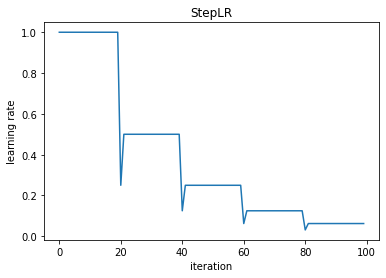

In [12]:
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
plot_scheduler(scheduler, num_iters=num_iters)

A related thing one might want to do is not decay the learning rate after so many iterations, but to decay the learning rate on *every iteration*. The way to do this is with the multiplicative scheduler `MultiplicativeLR`. Instead of taking a `gamma` decay factor, the implementation takes a function `i -> gamma`, usually just implemented as a lambda function (see below). When plotted, this LR scheduler just looks like a decaying exponential. Of course it does, as we're decaying by a constant multiplicative factor every iteration.

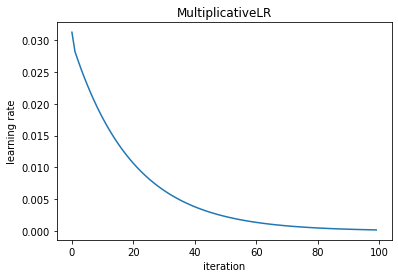

In [13]:
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda=lambda i: 0.95)
plot_scheduler(scheduler, num_iters=num_iters)

Both of these schedulers decay the learning rate over iterations. What if we want to do more exotic things like warm ups or restarts?

The most common such schedulers are cosine annealing with warm restarts `CosineAnnealingWarmRestarts`, and one-cycle learning `OneCycleLR`. Here's a plot of what the cosine annealing scheduler might look like. Notice that we start with the max learning rate specified in the optimizer, here `lr=1`, and decay it to `lr=0` every `T_0` steps. In this case, we time it so we do 5 decays over the course of `num_iters`. After each cycle, the learning rate "warm restarts" back up to its original learning rate. 

Why might we want to do this? There's a concept in computer science called *exploration vs exploitation*. Basically, when learning a task (as a human or computer), one often wants to spend some time exploring new options (i.e. bouncing around the loss surface at a higher learning rate), and (especially later in learning or life or whatever) spend more time exploiting (i.e. focusing hard on one particular section of the loss surface at a lower learning rate). Methods like cosine annealing essentially allow us to explore the loss surface more during training to see if there's a "better" minimum out there than the one we're zooming in on. If this explanation was too wishy washy for you, just know that such annealing schedulers have been shown to work very well in practice, often speeding up learning a good bit.

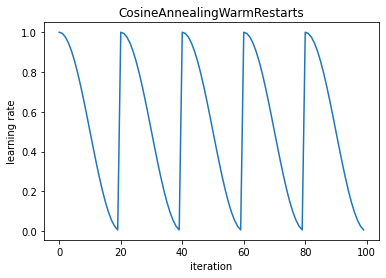

In [14]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=num_iters // 5)
plot_scheduler(scheduler, num_iters=num_iters)

Another, similar method to cosine annealing is the one-cycle learning rate scheduler. One cycle shares a lot of similarities with cosine annealing, but tends to slowly ramp up the learning rate after a warmup period (in the case of the plot below the first 30 iterations). Usually one-cycle iterations happen over the course of an *epoch*, which is a sequence of *batches* where the model has "seen" all the data. We'll describe epochs and batches more in the next tutorial. Suffice it to say, one-cycle is used in many state of the art papers nowadays because of how much it can speed up training. It also has the benefits of working well with certain architectures that need a warm-up period or they're prone to diverge early in training, transformers being perhaps the most notable example of this.

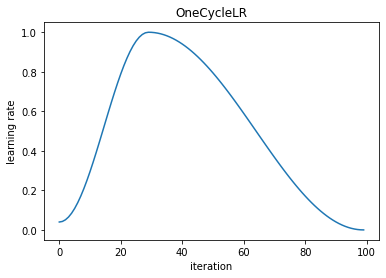

In [15]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1, total_steps=num_iters)
plot_scheduler(scheduler, num_iters=num_iters)

## Regularization

Recall from past tutorials that in practice it's usually bad to have zero loss or 100% accuracy on the training dataset, because it probably means you're just memorizing your data instead of discovering the underlying patterns in the data. This phenomenon is called **overfitting**. To help detect and prevent overfitting it's customary to keep a hold-out sample of the dataset that the model doesn't get trained on, and use that dataset to evaluate the performance of the model. Such hold-out datasets are called the **test set** or the **validation set**. A model trained on a training set that also performs well on the test set is said to **generalize**, just a fancy way of saying the model isn't just memorizing the data but actually learning its underlying patterns really well.

To see what overfitting looks like let's create a small linear dataset, split it into train and test sets, and try to fit the training set with an MLP of 8 layers, each hidden size of 500 neurons. The data will again be taken from the sklearn `make_blobs` function. We'll take 500 samples of 2 features (so we can plot the decision boundaries) and 3 classes. They're deliberately made to overlapt a good bit.

In [16]:
X, y = make_blobs(n_samples=500, n_features=2, centers=3, cluster_std=2.5, random_state=seed)
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).long().to(device)
X.shape, y.shape

(torch.Size([500, 2]), torch.Size([500]))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([400, 2]),
 torch.Size([400]),
 torch.Size([100, 2]),
 torch.Size([100]))

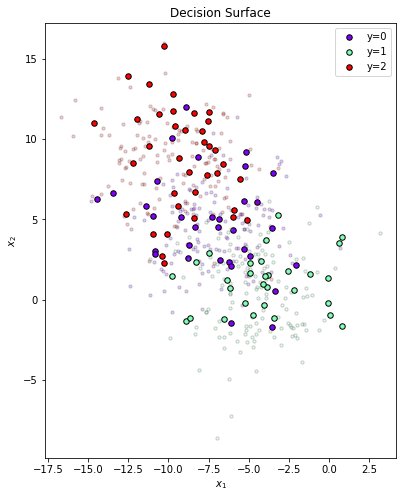

In [18]:
plot_data(X_train.cpu().numpy(), y_train.cpu().numpy(), X_test=X_test.cpu().numpy(), y_test=y_test.cpu().numpy())

In [19]:
num_features = X_train.shape[1]
num_hidden = 500
num_targets = len(set(y_train))

model = multilayer_mlp(num_features, num_targets, hidden_sizes = [500] * 6)
model = model.to(device)
model

Sequential(
  (0): Sequential()
  (1): Linear(in_features=2, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=500, bias=True)
  (4): ReLU()
  (5): Linear(in_features=500, out_features=500, bias=True)
  (6): ReLU()
  (7): Linear(in_features=500, out_features=500, bias=True)
  (8): ReLU()
  (9): Linear(in_features=500, out_features=500, bias=True)
  (10): ReLU()
  (11): Linear(in_features=500, out_features=500, bias=True)
  (12): ReLU()
  (13): Linear(in_features=500, out_features=400, bias=True)
)

Since I've no idea what a good learning rate would be for this model, let's use our LR finder function to see if we can identify a good one, being sure to pass in the same loss and optimizer to be used during training. It looks like somewhere close to 0.04 is the recommended choice, so let's try using that below.

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.76E-02


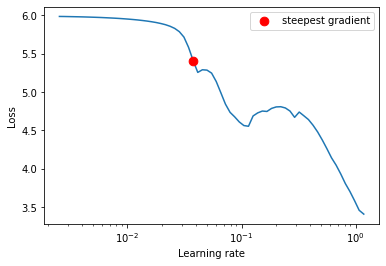

In [20]:
train_set = [(X_train[i], y_train[i]) for i in range(len(y_train))]
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=1)
lr_find(train_set, model, opt, loss_fn, start_lr=1e-3, end_lr=10, num_iter=100)

Before training this model, let's go ahead and package up our training loop into a simple function so we don't have to keep copy and pasting it. Since the data, model, optimizer, loss function, and (optionally) a scheduler can vary from problem to problem, we'll keep those outside the function and just pass them in during training. Notice that we also added an inference step to each iteration, which is intended evaluate how well the model is doing on the test set. It is important not to step the optimizer *or* the scheduler during inference. The `model.train()` vs `model.eval()` distinction will be explained below, and doesn't matter right now.

Now, for this particular problem, we'll train for 5000 epochs at the above learning rate. Notice that the training loss is an order of magnitude below the test loss. Moreover, the test loss actually appears to be increasing! It was as low as 0.0067 at `iter=2000`, but got up to 0.00988 by the end. This tendency is the hallmark of overfitting in deep learning:

**Overfitting in Deep Learning:** When the test loss stops decreasing and starts increasing during training. Note this has *nothing* to do with what the training loss is doing, so long as it's decreasing, or how much better the training loss might be than the test loss.

In [21]:
num_iters = 5000
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.04)

In [22]:
def train_model(X_train, y_train, model, opt, loss_fn, num_iters, X_test=None, y_test=None, scheduler=None):
    for i in tqdm(range(num_iters)):
        # training
        model = model.train()
        opt.zero_grad()
        yhat = model(X_train)
        loss = loss_fn(yhat, y_train)
        loss.backward()
        opt.step()
        if scheduler:
            scheduler.step()
        avg_train_loss = loss / len(X_train)
        # inference
        if X_test is not None and y_test is not None:
            model = model.eval()
            yhat = model(X_test)
            test_loss = loss_fn(yhat, y_test)
            avg_test_loss = test_loss / len(X_test)
        else:
            avg_test_loss = None
        if i % (num_iters // 10) == 0:
            print(f'iter = {i} \t\t train loss = {avg_train_loss} \t\t test loss = {avg_test_loss}')
    print(f'iter = {i} \t\t train loss = {avg_train_loss} \t\t test loss = {avg_test_loss}')
    return model

model = train_model(X_train, y_train, model, opt, loss_fn, num_iters, X_test=X_test, y_test=y_test)

  0%|          | 0/5000 [00:00<?, ?it/s]

iter = 0 		 train loss = 0.014980767853558064 		 test loss = 0.05939970165491104
iter = 500 		 train loss = 0.0012797480449080467 		 test loss = 0.0067044999450445175
iter = 1000 		 train loss = 0.0013154371408745646 		 test loss = 0.007470983080565929
iter = 1500 		 train loss = 0.0012678478378802538 		 test loss = 0.007872999645769596
iter = 2000 		 train loss = 0.001214978052303195 		 test loss = 0.008120756596326828
iter = 2500 		 train loss = 0.0011604863684624434 		 test loss = 0.008349109441041946
iter = 3000 		 train loss = 0.0011995667591691017 		 test loss = 0.008861290290951729
iter = 3500 		 train loss = 0.0011545511661097407 		 test loss = 0.008789866231381893
iter = 4000 		 train loss = 0.0011682977201417089 		 test loss = 0.009536593221127987
iter = 4500 		 train loss = 0.0010927650146186352 		 test loss = 0.009680821560323238
iter = 4999 		 train loss = 0.001102370209991932 		 test loss = 0.009882213547825813


The accuracy of the model on the training and test sets is given below. Notice the training loss is a good deal higher than the test loss. This is a *hint* that we may be overfitting, but by itself shouldn't be taken as conclusive. We should really look at what the test loss is doing.

Also look at the plot and notice how jagged the decision boundaries appear to be. This is another hint that we *might* be overfitting here.

In [23]:
yhat = model(X_train).detach()
y_pred = yhat.argmax(dim=-1).detach().long()
print(f'train accuracy: {accuracy_score(y_train.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())}')

yhat = model(X_test).detach()
y_pred = yhat.argmax(dim=-1).detach().long()
print(f'test accuracy: {accuracy_score(y_test.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())}')

train accuracy: 0.7825
test accuracy: 0.65


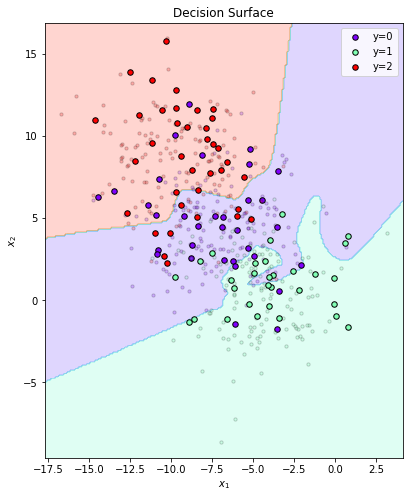

In [24]:
plot_data(X_train.cpu().numpy(), y_train.cpu().numpy(), X_test=X_test.cpu().numpy(), y_test=y_test.cpu().numpy(),
          model=model, h=0.1)

Why did we overfit this dataset? Well, we specified a huge model to fit a small number of points (yes, 500 points is small in deep learning). Just how big is this model? We can get that with the following function, which uses the pytorch `numel` method to get how many elements are in a tensor, and uses this method on all parameter tensors in the model, and sums them up to get the total number. It looks like this neural network already has over 1.45 million parameters! It's no surprise that a model that big can easily overfit a dataset with far fewer examples than the model has parameters (though this can and will be fixed below).

In [25]:
def num_params(model):
    return sum([p.numel() for p in model.parameters()])

num_params(model)

1454400

Traditionally, the most common thing one might do if our model was overfitting would be to:
1. Decrease the size of the model. Instead of a complicated model like an 8-layer neural network, maybe use a simpler model like a shallow network or perhaps just linear regression. In the age of deep learning though this approach is less advised. The reason being that you can often *still* get better results with a deeper network than a shallow network, even if you have lots more parameters that can overfit.
2. Decrease the number of features in our model using *feature selection* techniques. But in deep learning, throwing away data is almost always bad. Let's not throw away perfectly good features if we can help it.
3. Collect more training data. This is always an option. It turns out to be very hard to overfit large training sets even with huge deep learning models. But collecting training data is expensive, time consuming, and often just too impractical to do.

Supposing we were dead set to use this model on this dataset, what could we do to improve results? It turns out there exist a whole set of **regularization** techniques that can help make it harder for large models to overfit the dataset.

### Weight Decay

Perhaps the simplest regularization technique is called **weight decay** or **L2 regularization**. The idea here is to add a penalty term to the loss function that discourages it from letting weights grow too large during training. The closer the weights are to zero, the more the model acts like it has fewer parameters, since zeroing weights tends to zero out neurons. Suppose we have a loss function $L(\boldsymbol{\hat y}, \boldsymbol{y})$ and our neural network has total weights
$$\boldsymbol{w} \equiv (w_1,w_2,\cdots,w_m).$$
Then we can define an L2-regularized loss function $L_R(\boldsymbol{\hat y}, \boldsymbol{y})$ by
$$L_R(\boldsymbol{\hat y}, \boldsymbol{y}) \equiv L(\boldsymbol{\hat y}, \boldsymbol{y}) + \frac{\lambda}{2N} \boldsymbol{w}\cdot \boldsymbol{w} = L(\boldsymbol{\hat y}, \boldsymbol{y}) + \frac{\lambda}{2N} \big(w_1^2 + w_2^2 + \cdots + w_m^2 \big).$$
That is, it's just the regular loss added to a *penalty term* that's a just a sum of squares of *every single weight* in your neural network. The value $\lambda$ is the **weight decay rate**. It's another tunable hyperparameter you specify in advance when training a model.

**Remark:** For those who have done optimization before, notice that what we just did here was use the method of *Lagrange Multipliers* to introduce a *soft constraint* on the weights that they be small. It's a "soft" constraint since the model can tradeoff in deciding how small they should be using $\lambda$. In contrast, a *hard constraint* would say "under no circumstance can the weights get larger than 0.1", for example.

To see what weight decay does, remember that the goal of training is to minimize the (regularized) loss $L_R(\boldsymbol{\hat y}, \boldsymbol{y})$. With the added penalty term $\frac{\lambda}{2N} \boldsymbol{w}\cdot \boldsymbol{w}$, the model will want to try to keep the weights small during training so that this term doesn't blow up. The weight decay rate $\lambda$ controls the tradeoff between how badly the model wants to do well on fitting the dataset (the regular loss term), and how badly it wants to keep the weights small (the penalty term). Setting $\lambda$ appropriately creates a good tradeoff between these two competing objectives.

**Note:** The biases aren't generally affected by weight decay. It's only the weights we worry about blowing up. The biases are just additive terms, and there are far fewer of them than weights, so they contribute much less to overfitting.

In practice, weight decay is usually defined on the gradient descent updates instead of directly on the loss function itself. The mathematically inclined can show that the regularized gradient updates are given by
$$\boldsymbol{W}_{n+1} = \boldsymbol{W}_n - \alpha \frac{dL_R(\boldsymbol{W}_n,\boldsymbol{b}_n)}{d\boldsymbol{W}} = \bigg(1 - \frac{\lambda}{N}\bigg)\boldsymbol{W}_n - \alpha \frac{dL(\boldsymbol{W}_n,\boldsymbol{b}_n)}{d\boldsymbol{W}},$$
$$\boldsymbol{b}_{n+1} = \boldsymbol{b}_n - \alpha \frac{dL_R(\boldsymbol{W}_n,\boldsymbol{b}_n)}{d\boldsymbol{b}} = \boldsymbol{b}_n - \alpha \frac{dL(\boldsymbol{W}_n,\boldsymbol{b}_n)}{d\boldsymbol{b}}.$$

Notice the terms on the right involve gradients of the original loss $L$, not the regularized loss $L_R$. They look exactly like the usual gradient updates, except the weights get decayed by a factor of $\big(1 - \frac{\lambda}{N}\big)$ on each update, hence the name "weight decay". It's in this form that weight decay is typically implemented in practice. This means we can just use the regular loss function, but pass weight decay to the optimizer.

In pytorch, we can use weight decay by just passing in the value $\lambda$ that we want directly into the optimizer with the keyword `weight_decay`. Here's an example.

In [26]:
opt = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.01)
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0.01
)

### Dropout

Another way to regularize a model that's neural network specific is to use a special "layer" with no parameters called **dropout**. The idea is this: A model is more likely to overfit when any one neuron is allowed to dominate a prediction too much. We can thus regularize by preventing any one neuron from becoming too influential during training.

During **training** we can do the following:
- For a given hidden layer $\ell$ with $n_h$ hidden units, take its post activation outputs $\boldsymbol{a}$, which will have $n_h$ different values (the neurons of that layer).
- Instead of feeding all $n_h$ hidden units of $\boldsymbol{a}$ to the next linear layer, randomly sample a certain fraction $p$ of them to mask (i.e. zero out temporarily so they won't affect the output).
- The other fraction $1-p$ we'll allow to pass into the activation function and affect the output.
- Each time we pass through the layer, we sample a different set from $\boldsymbol{a}$ than we did last time, but still only a $p$ fraction of them
- Do this each iteration, for each layer, until training is complete. Note each layer can have different fractions $p$ to mask.

Here's a figure showing what applying dropout during training looks like. For each iteration, i.e. each forward pass through the network, the ones that are X'd out will change, but the *number* that are X'd out will generally be about the same, depending on $p$.

<img src="https://miro.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png" alt="dropout" width="500">

In pytorch, we can create a dropout layer using `nn.Dropout(p)`, where `p` is the fraction of neurons to mask as described above. Below is what the dropout layer looks like.

**Important:** When doing **inference** on the model, i.e. when making predictions on the test set (or any future dataset), we don't want to keep dropout on. We want to use all the neurons we've got to ensure that our predictions aren't random, but completely stable and deterministic. This is achieved in pytorch by calling `model = model.eval()`, which (among other things turns dropout off. We can turn it back on by calling `model = model.train()`.

In [27]:
p = 0.5
dropout = nn.Dropout(p)
dropout

Dropout(p=0.5, inplace=False)

### Regularization Example

Let's use weight decay and dropout for the above `make_blobs` example and see if we can reign in the overfitting. We'll use the same model as above, just with dropout added after each linear layer (except the output layer, you don't usually want one there). We'll take `p=0.2` and `weight_decay=0.001`. 

How did I arrive at this choice of hyperparameters, you might ask? Lots of times running this thing to see what would give the best result, with all the other hyperparameters from above fixed. Don't think I'm a magician and pulled them out of a hat or anything. Tuning neural nets is a whole lot of trial and error, even with a learning rate finder.

We can see that we've managed to cut our test error rate down to 0.79, but at the cost of the training error being higher. That's what regularization will often do. The same deal with the accuracy. The training accuracy has decreased to 67.5%, but the test accuracy has increased to 68%.

Notice also that the decision boundary looks a lot smoother than the previous one. Again, that's not indicative that we're doing a good or bad job, but it is perhaps pleasing to the eye.

In [28]:
model = multilayer_mlp(num_features, num_targets, hidden_sizes = [500] * 6, p=0.2)
model = model.to(device)
model

Sequential(
  (0): Sequential()
  (1): Linear(in_features=2, out_features=500, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=500, out_features=500, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Linear(in_features=500, out_features=500, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.2, inplace=False)
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.2, inplace=False)
  (19): Linear(in_features=500, out_features=400, bias=True)
)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.83E-01


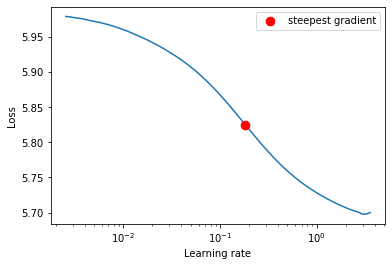

In [29]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1)
lr_find(train_set, model, opt, loss_fn, start_lr=1e-3, end_lr=10, num_iter=100)

In [30]:
num_iters = 5000
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.2, weight_decay=0.01)

model = train_model(X_train, y_train, model, opt, loss_fn, num_iters, X_test=X_test, y_test=y_test)

  0%|          | 0/5000 [00:00<?, ?it/s]

iter = 0 		 train loss = 0.014951230026781559 		 test loss = 0.05803108587861061
iter = 500 		 train loss = 0.0018127067014575005 		 test loss = 0.0070189302787184715
iter = 1000 		 train loss = 0.0016455112490803003 		 test loss = 0.007411864586174488
iter = 1500 		 train loss = 0.002206274075433612 		 test loss = 0.008767444640398026
iter = 2000 		 train loss = 0.002438917988911271 		 test loss = 0.007566189859062433
iter = 2500 		 train loss = 0.0025181954260915518 		 test loss = 0.009881265461444855
iter = 3000 		 train loss = 0.0017234821571037173 		 test loss = 0.010305271483957767
iter = 3500 		 train loss = 0.0019525201059877872 		 test loss = 0.007307842839509249
iter = 4000 		 train loss = 0.0014455519849434495 		 test loss = 0.006987483706325293
iter = 4500 		 train loss = 0.0024226231034845114 		 test loss = 0.011402793228626251
iter = 4999 		 train loss = 0.0015118346782401204 		 test loss = 0.00792484637349844


In [31]:
yhat = model(X_train).detach()
y_pred = yhat.argmax(dim=-1).detach().long()
print(f'train accuracy: {accuracy_score(y_train.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())}')

yhat = model(X_test).detach()
y_pred = yhat.argmax(dim=-1).detach().long()
print(f'test accuracy: {accuracy_score(y_test.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())}')

train accuracy: 0.675
test accuracy: 0.68


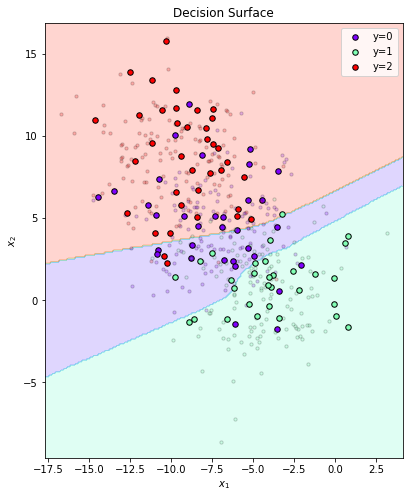

In [32]:
plot_data(X_train.cpu().numpy(), y_train.cpu().numpy(), X_test=X_test.cpu().numpy(), y_test=y_test.cpu().numpy(),
          model=model, h=0.1)

## Normalization

It turns out that, like all parametric models, neural networks are strongly affected by the scale of the data. If features are way out of scale with each other the model will typically train poorly. For gradient descent to work, you'll either need to use a really small learning rate, or rescale your data prior to training. Since we want to use large learning rates and train our models quickly, rescaling the data seems like the smarter move. This is called **normalization**. In fact, with neural nets, we don't just want to normalize the data (i.e. the input layer), we want to normalize *all layers*. This will lead to techniques like batch normalization and layer normalization.

Too see what normalization does, let's start with input layer normalization, i.e. normalizing the input features. Consider the following input data `X` with 100 examples of 3 features. We can see how skewed the features are by looking at a histogram of each feature and overlaying them on top of each other. In this case, it looks like the feature $x_0$ has a mean around 0 with a pretty large spread. Feature $x_1$ has a somewhat higher mean, but a smaller spread with a sharper peak. And feature $x_2$ has a much higher mean around 1000 and a still smaller spread and higher peak. It's not at all the case that these features are on the same scale.

In [33]:
def gen_data(n_samples, means, stds):
    x0 = stds[0] * torch.randn(n_samples).reshape(-1, 1) + means[0]
    x1 = stds[1] * torch.randn(n_samples).reshape(-1, 1) + means[1]
    x2 = stds[2] * torch.randn(n_samples).reshape(-1, 1) + means[2]
    return torch.cat([x0, x1, x2], dim=1)
    
x = gen_data(100, [1, 100, 1000], [100, 10, 1])
x.shape

torch.Size([100, 3])

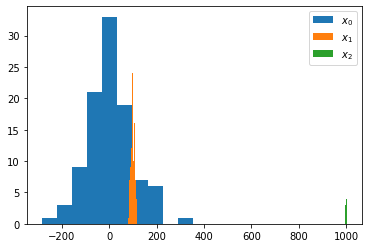

In [34]:
plt.hist(x[:, 0].numpy(), label='$x_0$')
plt.hist(x[:, 1].numpy(), label='$x_1$')
plt.hist(x[:, 2].numpy(), label='$x_2$')
plt.legend()
plt.show()

There are several ways to normalize data, with different domains often preferring different normalization methods. Probably the most common is **standardization**, a method from statistics where one normalizes each feature to have a mean 0 and standard deviation 1, called centering and scaling. If $x_j$ is a feature of examples that have mean $\mu_j$ and standard deviation $\sigma_j$, we can normalize it to a new feature standardized feature $\hat x_j$ via
$$\hat x_j \equiv \frac{x_j - \mu_j}{\sigma_j}.$$
By design, all $\hat x_j$ will have mean 0 and standard deviation 1. Note each feature will have its own $\mu_j$ and $\sigma_j$ to normalize by. You don't want to use the same $\mu$ and $\sigma$ for every feature or you haven't really normalized your data all.

Using broadcasting rules we can normalize a dataset `x` by subtracting a *row vector* of column means and dividing by a *row vector* of column standard deviations. It's a simple one-liner. Once we've done this, the histogram shows each feature to be a lot better scaled.

In [35]:
x_normed = (x - torch.mean(x, dim=0)) / torch.std(x, dim=0)
x_normed.shape

torch.Size([100, 3])

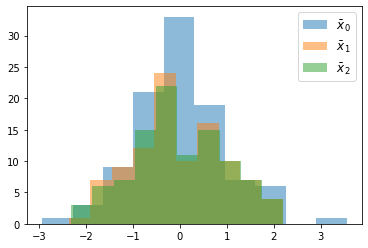

In [36]:
plt.hist(x_normed[:, 0].numpy(), label=r'$\hat x_0$', alpha=0.5)
plt.hist(x_normed[:, 1].numpy(), label=r'$\hat x_1$', alpha=0.5)
plt.hist(x_normed[:, 2].numpy(), label=r'$\hat x_2$', alpha=0.5)
plt.legend(fontsize=12)
plt.show()

### Batch Normalization

The real kick here is that with neural networks we want to do this for *each layer*, not just the inputs, as it will make training deeper networks much easier when neurons in a layer are on similar scales to each other. Generally we'll want to do this *after* each *linear layer* and *before* applying the *activation function*. So if a linear layer has
$$\boldsymbol{z}_{\ell} = \boldsymbol{W}_{\ell} \boldsymbol{a}_{\ell-1} + \boldsymbol{b}_{\ell},$$
we'll want to normalize it to be
$$\boldsymbol{\hat z}_{\ell} \equiv \frac{\boldsymbol{z}_{\ell} - \boldsymbol{\mu}_{\ell}}{\boldsymbol{\sigma}_{\ell}},$$
where $\boldsymbol{\mu}_{\ell}$ is the mean across all examples of the inputs in layer $\ell$, and $\boldsymbol{\sigma}_{\ell}$ the standard deviation of those inputs across all examples.

Excuse the slight abuse of notation here. This formula is already assumed to be vectorized, hence the change to bolded notation. So $\boldsymbol{z}_{\ell}$ is a vector with $n_h$ features. And *each of those features* will be normalized by *its own mean and std*.

Now, it seems like the thing to do would be to pass $\boldsymbol{\hat z}_{\ell}$ into the activation function like we would usually do $\boldsymbol{z}_{\ell}$, but that's not quite what we want to do. The issue is that we have normalized our layer to have the same distribution across all neurons, a standard Gaussian. But there's no a priori reason that those features should necessarily be standard Gaussians. We want our learned features to be as expressive as possible.

The trick for both 1) taking advantage of the benefits of normalized layers in training, while simultaneously 2) having features as expressive as possible can be accomplished as follows: What we'll do is, for each neuron in the layer, introduce two learned parameters, a scale parameter $\gamma_j$ and a shift parameter $\beta_j$. Then we can rescale that neuron's input $z_j$ using
$$\hat z_j = \frac{z_j - \mu_j}{\sigma_j},$$
$$\tilde z_j = \alpha_j \hat z_j + \beta_j.$$

For each hidden layer $\ell$ this will give two parameter vectors: a scale vector $\boldsymbol{\gamma}_{\ell}=(\gamma_1,\cdots,\gamma_{n_h})$, and a shift vector $\boldsymbol{\beta}_{\ell}=(\beta_1,\cdots,\beta_{n_h})$. Using these, we can *elementwise multiply* $\boldsymbol{\gamma}_{\ell}, \boldsymbol{\hat z}_{\ell}$ and add $\boldsymbol{\beta}_{\ell}$ to get the *final* linear layer outputs that'll then be fed into the activation function. 
All together, each layer might look like this from end to end:
$$\boldsymbol{z}_{\ell} = \boldsymbol{W}_{\ell} \boldsymbol{a}_{\ell-1} + \boldsymbol{b}_{\ell},$$
$$\boldsymbol{\hat z}_{\ell} = \frac{\boldsymbol{z}_{\ell} - \boldsymbol{\mu}_{\ell}}{\boldsymbol{\sigma}_{\ell}},$$
$$\boldsymbol{\tilde z}_{\ell} = \boldsymbol{\gamma}_{\ell} \boldsymbol{\hat z}_{\ell} + \boldsymbol{\beta}_{\ell},$$
$$\boldsymbol{a}_{\ell} = f_{\ell}(\boldsymbol{\tilde z}_{\ell}).$$
These will allow each neuron to have its own mean and standard deviation, but only after we've normalized the data. The neural network can figure out for itself what the best choices for these parameters are by learning from the data. This technique is called **batch normalization** (batch norm), and has been shown to be very powerful in helping stably train deep neural networks of all kinds.

In pytorch, we can create a (1-dim) batch norm layer using `nn.BatchNorm1d`. If that layer has `num_hidden` neurons then batch norm will have `2 * num_hidden` parameters: `num_hidden` scale parameters $\boldsymbol{\gamma}$, and `num_hidden` shift parameters $\boldsymbol{\beta}$.

In [37]:
num_hidden = 3
batch_norm = nn.BatchNorm1d(num_hidden)
list(batch_norm.parameters()) # these are initialized param values, not yet learned

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

### Layer Normalization

For completeness, there's also another normalization technique related to batch norm that's becoming more popular, called **layer normalization** (layer norm). It's almost exactly the same as batch norm, except with one subtle difference: Instead of calculating $\boldsymbol{\mu}_{\ell}$ and $\boldsymbol{\sigma}_{\ell}$ across *all examples* in a batch for *each neuron*, they're calculated for *each example* separately across *all neurons* in the layer.

<img src="https://i.stack.imgur.com/E3104.png" alt="layer norm" width="500">

This very subtle change has increasingly been shown to work well in many applications, and is widely used in the most modern neural architectures, especially in sequential architectures like transformers and RNNs. Roughly speaking, right now it seems layer norms are more popular with NLP applications, and batch norms with computer vision applications. But this may well change in the next few years.

In pytorch, we can create a layer norm layer using `nn.LayerNorm`. It has the same number and type of parameters as batch norm does, they're just calculated slightly differently, as described above.

In [38]:
num_hidden = 3
layer_norm = nn.LayerNorm(num_hidden)
list(layer_norm.parameters()) # these are initialized param values, not yet learned

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

## Example: A Deeper Neural Network

Emboldened with all these neat new tricks, let's try to train a truly deep neural network of 25 layers on a bigger `make_blobs` dataset of 5000 examples with 5 classes. To make training more friendly to the CPU, I'll cut the hidden sizes down to just 50 neurons. That cuts us down to only 84k parameters.

We'll do a little bit of everything here. We'll use an LR finder, a dropout of `p=0.1`, no weight decay, and the fancy cosine annnealing LR scheduler.

In [39]:
X, y = make_blobs(n_samples=5000, n_features=2, centers=5, cluster_std=1., random_state=seed)
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).long().to(device)
X.shape, y.shape

(torch.Size([5000, 2]), torch.Size([5000]))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([4000, 2]),
 torch.Size([4000]),
 torch.Size([1000, 2]),
 torch.Size([1000]))

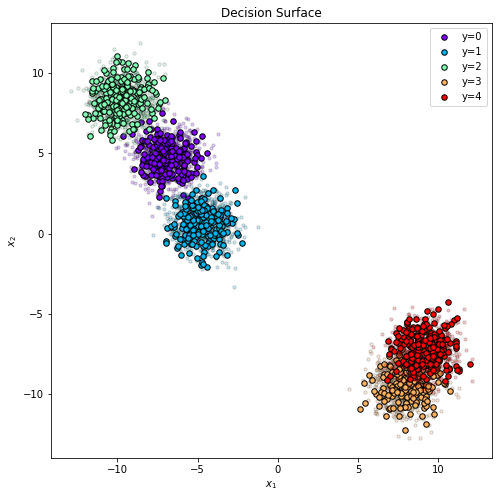

In [41]:
plot_data(X_train.cpu().numpy(), y_train.cpu().numpy(), X_test=X_test.cpu().numpy(), y_test=y_test.cpu().numpy(),
          h=0.1)

In [42]:
n_hidden_layers = 25
model = multilayer_mlp(num_features, num_targets, hidden_sizes = [50] * n_hidden_layers, p=0.1, 
                       normalization=nn.BatchNorm1d)
model = model.to(device)

In [43]:
num_params(model)

84250

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-01


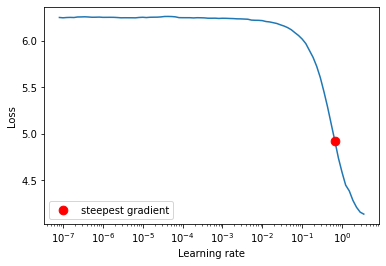

In [44]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=1, weight_decay=0)
lr_find(train_set, model, opt, loss_fn, start_lr=1e-8, end_lr=10, num_iter=100)

Let's now train the model for 1000 iterations and see what happens. It looks like after only a couple hundred interations we're already at the best training and test loss we're gonna get. The accuracies are comparable, with a training accuracy of 94% and a test accuracy of 95%. We may even be *underfitting* slightly. What could we do to improve this? Maybe try lowering the dropout parameter `p` some more, or turning it off. 

It's pretty interesting though that a 25 layer model with 84k parameters still cannot overfit this tiny dataset. This seems to be a general fact about deep learning. With enough data and even the tiniest amount of regularization, it turns out to be quite hard to truly overfit the data with a deep neural network.

In [45]:
num_iters = 1000
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.6, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=num_iters)

model = train_model(X_train, y_train, model, opt, loss_fn, num_iters, X_test=X_test, y_test=y_test, 
                    scheduler=scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

iter = 0 		 train loss = 0.0015473074745386839 		 test loss = 0.005797527730464935
iter = 100 		 train loss = 7.482788350898772e-05 		 test loss = 0.00020250627130735666
iter = 200 		 train loss = 5.791392322862521e-05 		 test loss = 0.00015526896459050477
iter = 300 		 train loss = 5.559741475735791e-05 		 test loss = 0.0001539760414743796
iter = 400 		 train loss = 5.959882037132047e-05 		 test loss = 0.0001427625393262133
iter = 500 		 train loss = 5.3170049795880914e-05 		 test loss = 0.00016393748228438199
iter = 600 		 train loss = 4.837887536268681e-05 		 test loss = 0.00013866346853319556
iter = 700 		 train loss = 5.0997219659620896e-05 		 test loss = 0.00015647611871827394
iter = 800 		 train loss = 5.063945354777388e-05 		 test loss = 0.00014884272241033614
iter = 900 		 train loss = 4.7883928345981985e-05 		 test loss = 0.0001526972628198564
iter = 999 		 train loss = 4.923124652123079e-05 		 test loss = 0.00015340531535912305


In [46]:
yhat = model(X_train).detach()
y_pred = yhat.argmax(dim=-1).detach().long()
print(f'train accuracy: {accuracy_score(y_train.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())}')

yhat = model(X_test).detach()
y_pred = yhat.argmax(dim=-1).detach().long()
print(f'test accuracy: {accuracy_score(y_test.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())}')

train accuracy: 0.939
test accuracy: 0.949


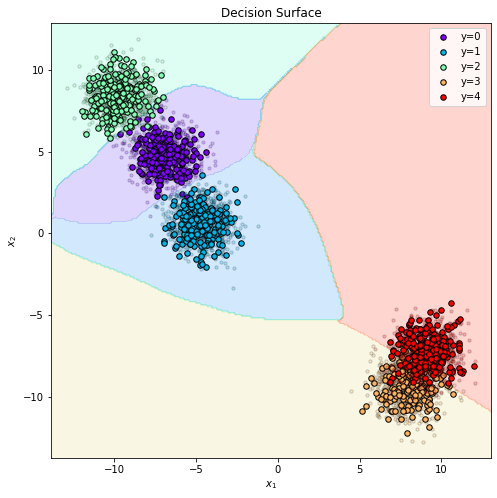

In [47]:
plot_data(X_train.cpu().numpy(), y_train.cpu().numpy(), X_test=X_test.cpu().numpy(), y_test=y_test.cpu().numpy(),
          model=model, h=0.1)

Just out of curiosity, let's see how well a baseline classical model might do. We'll try training the same data on a simple random forest with 100 trees. Notice even it already hits 94.4% test accuracy here. This is a pretty easy dataset to fit after all. With some tuning, a random forest might do just as well as our 25 layer neural net. Don't expect this to always be true though.

In [48]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
model.score(X_test.cpu().numpy(), y_test.cpu().numpy())

0.944